## Comparing media sentiment vs source bias

In [6]:
import json
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [18]:
# load bias data ../data/documents_bias.json
ordinal_bias = ['Left', 'Left-Center', 'Least Biased', 'Right-Center', 'Right']
bias_text = {float(i+1): bias for i, bias in enumerate(ordinal_bias)}
bias_text[None] = None

with open('../data/documents_bias.json') as f:
    bias_data = {doc_id: bias_text[doc['bias_rating']] for doc_id, doc in json.load(f).items()}

In [23]:
# load sentiment data ../data/all_windows_classified.json
with open('../data/all_windows_classified.json') as f:
    instances = json.load(f)

ordinal_sentiment = ['positive', 'neutral', 'negative']
sentiment_data = {}

for instance_id, instance in instances.items():
    doc_id = instance_id.split('_')[0]
    sentiment = max(instance['sentiment'], key=instance['sentiment'].get)
    if doc_id not in sentiment_data:
        sentiment_data[doc_id] = []
    sentiment_data[doc_id].append(sentiment)

### Using Cross-Tabs

In [24]:
# Convert the first dictionary to a DataFrame
bias_df = pd.DataFrame(list(bias_data.items()), columns=['id', 'bias'])
bias_df['bias'] = pd.Categorical(bias_df['bias'], categories=ordinal_bias, ordered=True)

# Flatten the second dictionary and convert it to a DataFrame
sentiment_df = pd.DataFrame([(k, v) for k, vals in sentiment_data.items() for v in vals],
                            columns=['id', 'sentiment'])
sentiment_df['sentiment'] = pd.Categorical(sentiment_df['sentiment'], categories=ordinal_sentiment, ordered=True)

# Merge the two DataFrames on the 'id' column
merged_df = pd.merge(bias_df, sentiment_df, on='id', how='inner')

# Create a cross-tabulation of ordinal values and sentiment labels
crosstab = pd.crosstab(merged_df['sentiment'], merged_df['bias'])

# Print the cross-tabulation
print(crosstab)

bias       Left  Left-Center  Least Biased  Right-Center  Right
sentiment                                                      
positive     66          167           167            66     64
neutral     137          240           237           147    143
negative     30           94            40            37     88


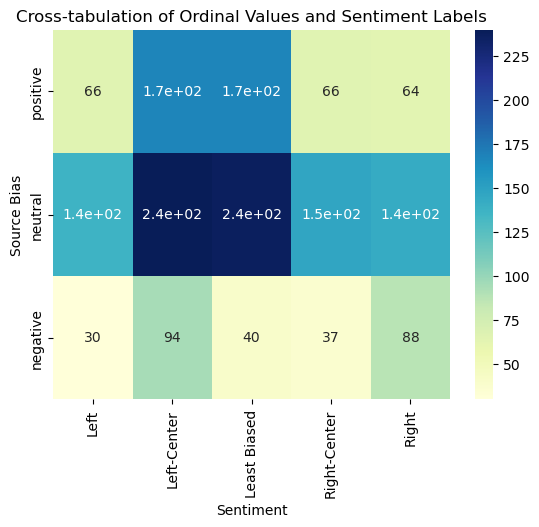

In [25]:
# Create a heatmap of the cross-tabulation
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", cbar=True)

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Source Bias')
plt.title('Cross-tabulation of Ordinal Values and Sentiment Labels')

# Show the plot
plt.show()

bias           Left  Left-Center  Least Biased  Right-Center     Right
sentiment                                                             
positive   0.283262     0.333333      0.376126         0.264  0.216949
neutral    0.587983     0.479042      0.533784         0.588  0.484746
negative   0.128755     0.187625      0.090090         0.148  0.298305


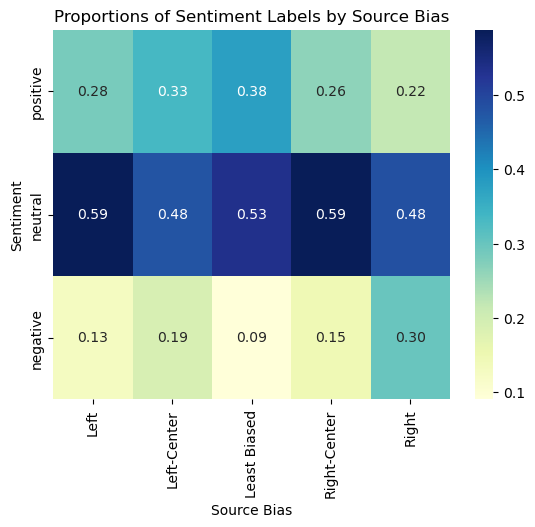

In [27]:
# Calculate proportions by normalizing the values in each row
crosstab_normalized = crosstab.div(crosstab.sum(axis=0), axis=1)

# Print the normalized cross-tabulation (proportions)
print(crosstab_normalized)

# Create a heatmap of the normalized cross-tabulation (proportions)
sns.heatmap(crosstab_normalized, annot=True, cmap="YlGnBu", cbar=True, fmt=".2f")

# Add labels and title
plt.xlabel('Source Bias')
plt.ylabel('Sentiment')
plt.title('Proportions of Sentiment Labels by Source Bias')

# Show the plot
plt.show()

### Using Random Forests

In [34]:
# Get date information
with open('../data/documents_bias.json') as f:
    date_data = {doc_id: doc['date'] for doc_id, doc in json.load(f).items()}

# Add the date information to the bias_df DataFrame
bias_df['date'] = bias_df['id'].map(date_data)

# Convert the date column to a datetime object and extract year, month, and day
bias_df['date'] = pd.to_datetime(bias_df['date'])
bias_df['year'] = bias_df['date'].dt.year
bias_df['month'] = bias_df['date'].dt.month
bias_df['day'] = bias_df['date'].dt.day

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

# Merge the bias_df and sentiment_df DataFrames (as in previous code)
df = pd.merge(bias_df, sentiment_df, on='id', how='inner')

# Encode the 'bias' and 'sentiment' columns using LabelEncoder
label_encoder_bias = LabelEncoder()
label_encoder_sentiment = LabelEncoder()
df['bias_encoded'] = label_encoder_bias.fit_transform(df['bias'])
df['sentiment_encoded'] = label_encoder_sentiment.fit_transform(df['sentiment'])

# Add the date components (year, month, day) to the independent variables
X = df[['bias_encoded', 'year', 'month', 'day']]
y = df['sentiment_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Independent variables (source bias and date components)
    y,  # Dependent variable (sentiment)
    test_size=0.2,
    random_state=42
)

# Apply RandomOverSampler to oversample minority classes in the training set
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV with the Random Forest Classifier and the hyperparameter grid
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy')

# Train the model on the resampled training data and perform hyperparameter tuning
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model found by GridSearchCV to make predictions on the testing data
best_rf_clf = grid_search.best_estimator_
y_pred = best_rf_clf.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred, target_names=ordinal_sentiment))

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

    positive       0.30      0.60      0.40       112
     neutral       0.72      0.55      0.63       534
    negative       0.52      0.55      0.53       297

    accuracy                           0.56       943
   macro avg       0.52      0.57      0.52       943
weighted avg       0.61      0.56      0.57       943



## Frequency of Coverage by Source Bias

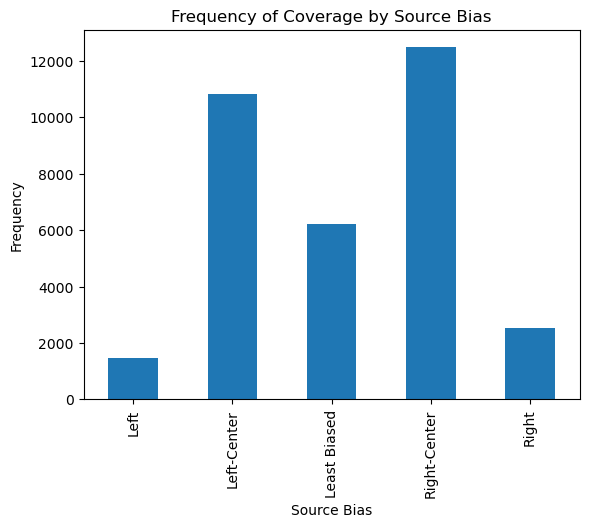

In [57]:
# Define the desired order of the bias categories
bias_order = ["Left", "Left-Center", "Least Biased", "Right-Center", "Right"]

# Convert the 'bias' column to a categorical data type with the specified order
bias_df['bias'] = pd.Categorical(bias_df['bias'], categories=bias_order, ordered=True)

# Create the bar chart with the frequency of coverage by source bias
# The bars will be ordered based on the specified order of categories
bias_df['bias'].value_counts(sort=False).plot(kind='bar')
plt.title('Frequency of Coverage by Source Bias')
plt.xlabel('Source Bias')
plt.ylabel('Frequency')
plt.show()

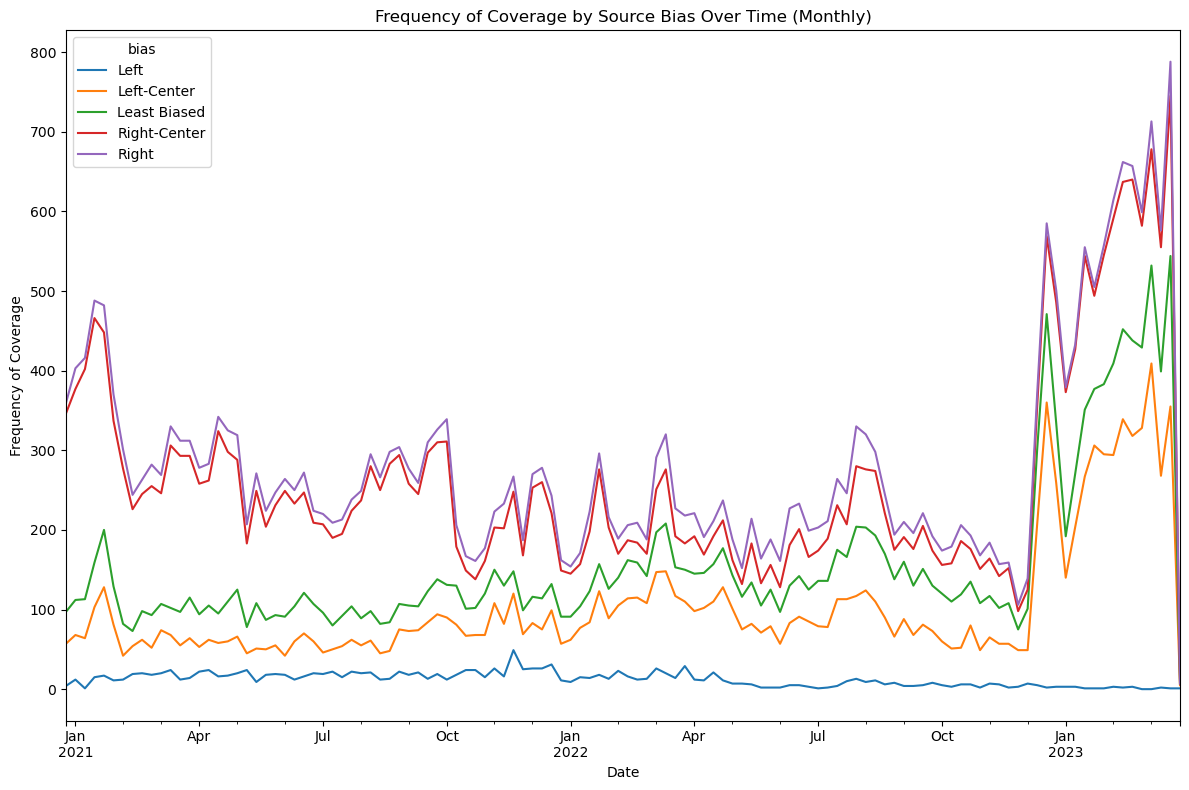

In [50]:
# Assuming bias_df contains 'date', 'bias', and 'id' columns
# 'date' - the date associated with each document
# 'bias' - the source bias category for each document
# 'id' - the unique identifier for each document

# Group the data by both date and bias category, and count the frequency of coverage for each group
coverage_by_date_bias = bias_df.groupby(['date', 'bias']).size().reset_index(name='frequency')

# Pivot the data to create a DataFrame with date as the index and bias categories as columns
coverage_pivot = coverage_by_date_bias.pivot(index='date', columns='bias', values='frequency').fillna(0)

# Sort the DataFrame by date
coverage_pivot.sort_index(inplace=True)

# Resample the data into monthly intervals and sum the frequencies within each interval
coverage_resampled = coverage_pivot.resample('W').sum()

# Plot the stacked line chart
ax = coverage_resampled.plot(kind='line', stacked=True, figsize=(12, 8))

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Frequency of Coverage')
ax.set_title('Frequency of Coverage by Source Bias Over Time (Weekly)')

# Show the plot
plt.tight_layout()
plt.show()


#### Now let's look at the same data, but with important dates highlighted

In [45]:
# Create a list of important dates from ../data/bill_data.json
with open('../data/bill_data.json') as f:
    bill_data = json.load(f)

bill_introduced_dates = [bill['introduced'] for bill in bill_data.values()]
last_action_dates_unix = [bill['last_action_timestamp'] for bill in bill_data.values()]

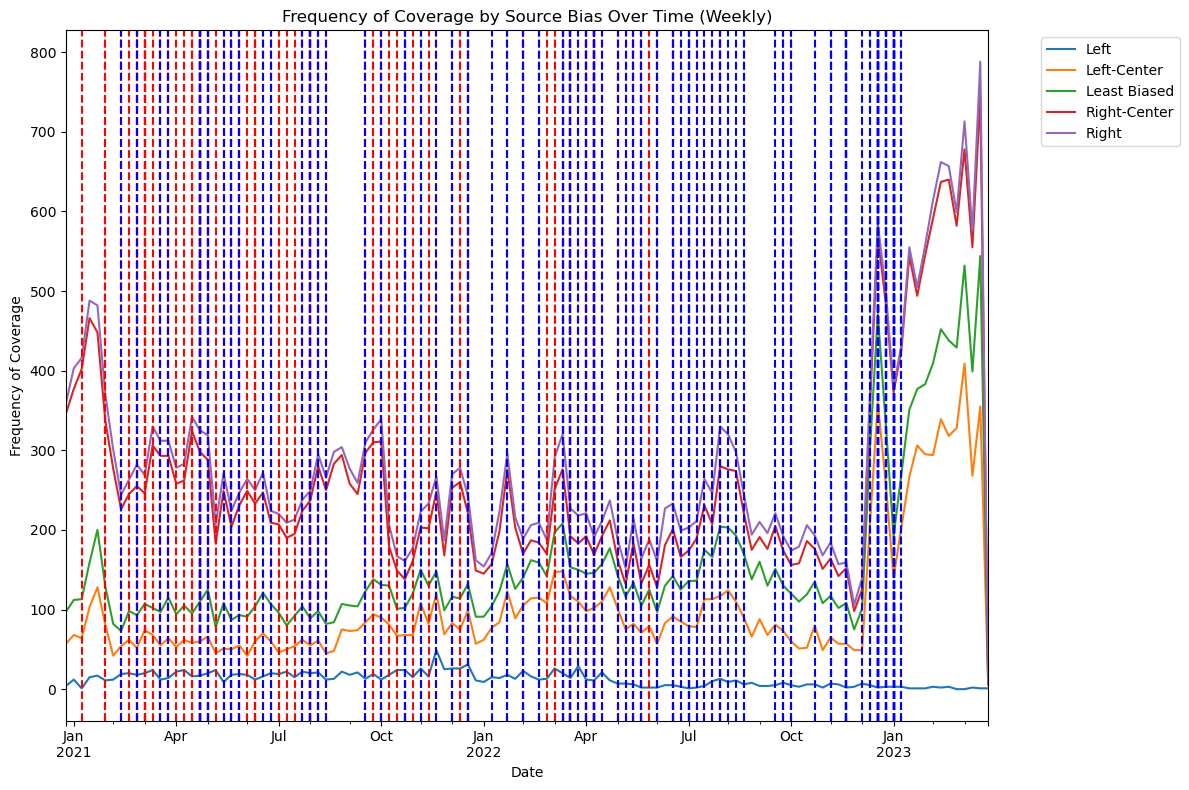

In [53]:
# Plot the stacked line chart
ax = coverage_resampled.plot(kind='line', stacked=True, figsize=(12, 8))

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Frequency of Coverage')
ax.set_title('Frequency of Coverage by Source Bias Over Time (Weekly)')

# Add vertical lines for bill introduced dates
for date in bill_introduced_dates:
    ax.axvline(pd.Timestamp(date), color='red', linestyle='--')

# Add vertical lines for last action dates (convert Unix timestamps to datetime objects)
for unix_timestamp in last_action_dates_unix:
    date = pd.Timestamp(unix_timestamp, unit='s')
    ax.axvline(date, color='blue', linestyle='--')

# Add a legend to the plot (bbox_to_anchor and loc adjust the legend position to avoid overlap)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

#### Hmmmm.... that's too many dates. Let's just look at the top 3 most frequent bills? Later though.

### Let's see what periods have the most coverage from each category

In [63]:
# Find the week with the highest coverage for each bias category
max_coverage_weeks = coverage_resampled.idxmax()

# Print the results
for bias, week in max_coverage_weeks.items():
    coverage = coverage_resampled.loc[week, bias]
    print(f"'{bias}': {coverage} -> {week}")

'Left': 49 -> 2021-11-21 00:00:00+00:00
'Left-Center': 409 -> 2023-03-05 00:00:00+00:00
'Least Biased': 189 -> 2023-03-19 00:00:00+00:00
'Right-Center': 307 -> 2021-01-17 00:00:00+00:00
'Right': 50 -> 2022-07-31 00:00:00+00:00


### Now let's see what bills were introduced or had their last action during these periods

In [68]:
# Convert bill_introduced_dates and last_action_dates_unix to Pandas Timestamps
bill_introduced_dates = pd.to_datetime(bill_introduced_dates).tz_localize(None)
last_action_dates_unix = pd.to_datetime(last_action_dates_unix, unit='s').tz_localize(None)

# Initialize lists to store the introduced and last action dates that fall within the periods
introduced_dates_in_period = []
last_action_dates_in_period = []

# Check if the dates fall within the periods
for bias, week in max_coverage_weeks.items():
    coverage = coverage_resampled.loc[week, bias]
    print(f"'{bias}': {coverage} -> {week}")

    # Calculate the start and end dates of the period (week), and remove time zone information
    start_date = week.tz_localize(None)
    end_date = (week + pd.DateOffset(weeks=1)).tz_localize(None)

    # Check if bill_introduced_dates are within the period
    for date in bill_introduced_dates:
        if start_date <= date < end_date:
            introduced_dates_in_period.append(date)

    # Check if last_action_dates_unix are within the period
    for date in last_action_dates_unix:
        if start_date <= date < end_date:
            last_action_dates_in_period.append(date)

# Print the results
print("Bill introduced dates within the periods:", introduced_dates_in_period)
print("Last action dates within the periods:", last_action_dates_in_period)

'Left': 49 -> 2021-11-21 00:00:00+00:00
'Left-Center': 409 -> 2023-03-05 00:00:00+00:00
'Least Biased': 189 -> 2023-03-19 00:00:00+00:00
'Right-Center': 307 -> 2021-01-17 00:00:00+00:00
'Right': 50 -> 2022-07-31 00:00:00+00:00
Bill introduced dates within the periods: []
Last action dates within the periods: [Timestamp('2022-08-02 06:00:00')]


In [ ]:
# TODO: There's more to do here :)

### Let's just look at sentiment over time.

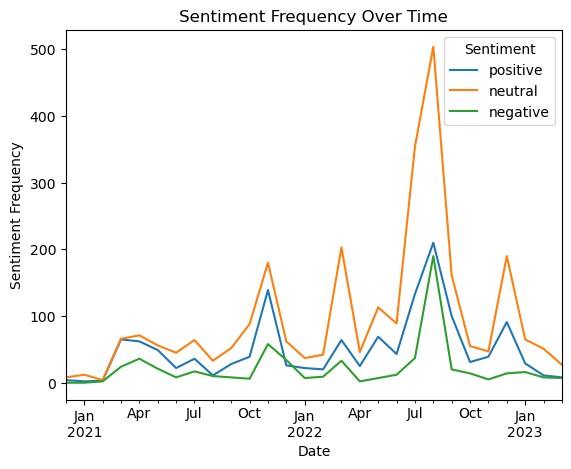

In [77]:
# Merge sentiment_df with date information from bias_df
merged_sentiment_df = pd.merge(sentiment_df, bias_df[['id', 'date']], on='id', how='inner')

# Convert the 'sentiment' column to a categorical variable with order
ordinal_sentiment = ['positive', 'neutral', 'negative']
merged_sentiment_df['sentiment'] = pd.Categorical(merged_sentiment_df['sentiment'], categories=ordinal_sentiment, ordered=True)

# Set 'date' as the DataFrame's index
merged_sentiment_df.set_index('date', inplace=True)

# Resample the data by month (or any other frequency of your choice)
sentiment_resampled = merged_sentiment_df.resample('M')

# Count sentiment frequencies for each month
sentiment_counts = sentiment_resampled['sentiment'].value_counts().unstack().fillna(0)

# Plot the stacked line chart showing sentiment frequencies over time
sentiment_counts.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Sentiment Frequency')
plt.title('Sentiment Frequency Over Time')
plt.legend(title='Sentiment')
plt.show()


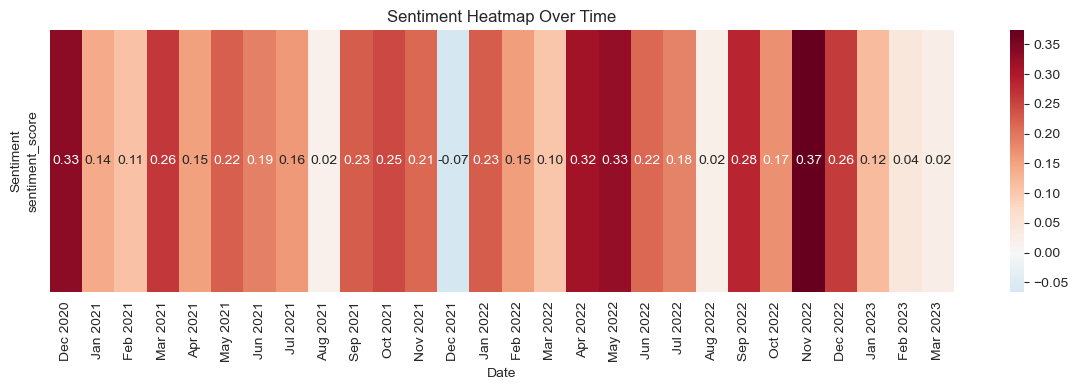

In [88]:
# Merge sentiment_df with date information from bias_df
merged_sentiment_df = pd.merge(sentiment_df, bias_df[['id', 'date']], on='id', how='inner')

# Convert the 'sentiment' column to numerical scores
sentiment_scores = {'positive': 1, 'neutral': 0, 'negative': -1}
merged_sentiment_df['sentiment_score'] = merged_sentiment_df['sentiment'].map(sentiment_scores).astype(float)

# Set 'date' as the DataFrame's index
merged_sentiment_df.set_index('date', inplace=True)

# Resample the data by month (or any other frequency of your choice) and calculate the mean sentiment score
sentiment_resampled = merged_sentiment_df.resample('M')['sentiment_score'].mean()

# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(sentiment_resampled.to_frame().T, cmap='RdBu_r', center=0, annot=True, fmt=".2f", cbar=True, ax=ax)

# Set the x-axis tick labels to match the dates in the sentiment_resampled DataFrame
ax.set_xticklabels([date.strftime('%b %Y') for date in sentiment_resampled.index])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment Heatmap Over Time')

# Show the plot
plt.tight_layout()
plt.show()